In [1]:
import numpy as np
from gfmod import *

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import os.path as path

import lib.dist as dist
import lib.utils as utils

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix',
    'xtick.direction' : 'in' ,
    'xtick.labelsize' : 17.5 ,
    'xtick.top' : True ,
    'xtick.major.width' : 1.5,
    'xtick.major.size' : 6,
    'ytick.direction' : 'in' ,
    'ytick.labelsize' : 17.5 ,
    'ytick.right' : True ,
    'ytick.major.width' : 1.5,
    'ytick.major.size' : 6,
    'axes.labelsize' : 18,
    'legend.frameon' : False,
    'legend.fontsize' : 13,
    'legend.handlelength' : 1.5,
    'savefig.dpi' : 600, 
    'savefig.bbox' : 'tight',
    'axes.linewidth' : 1.5,
})
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
torch.__version__

'1.7.1'

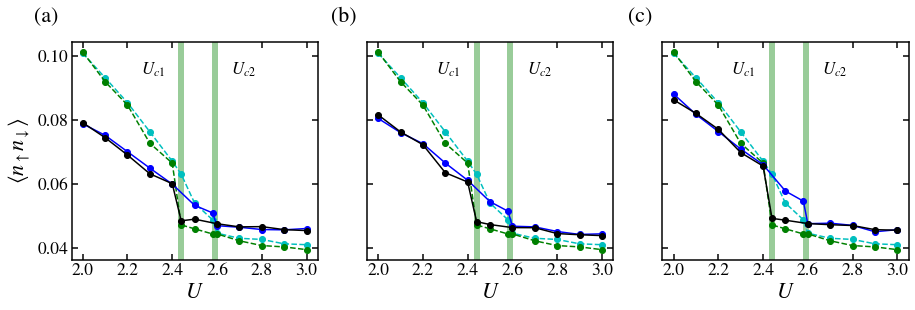

In [2]:
U_c1, U_c2 = 2.44, 2.59

fig, ax = plt.subplots(1,3, figsize=(15,4), sharey=True)

beta = 60
niwn = 180
ntau = niwn*5
iwn = np.array([1j*(2*n+1)*np.pi/beta for n in range(niwn)])
tau = np.linspace(0, beta, ntau)

U = np.array([0.01*i for i in range(100, 401)])
Ur_up, Ur_dn = [], []
for i, u in enumerate(U):
    if path.isfile(f'../3_VAE_recon/test_LR2/Bethe_14_beta{beta:d}/Giwn_recon-{u:.2f}.dat')==True: Ur_up.append(u)
    if path.isfile(f'../3_VAE_recon/test_LR2/Bethe_41_beta{beta:d}/Giwn_recon-{u:.2f}.dat')==True: Ur_dn.append(u)
Ur_up = np.array(Ur_up)
Ur_dn = np.array(Ur_dn)
Ur_len = len(Ur_up)+len(Ur_dn)
UUr = np.concatenate([Ur_up, Ur_dn])

docc_up = np.zeros_like(Ur_up)
docc_dn = np.zeros_like(Ur_dn)

for i in range (3):
    ax[i].axvline(U_c1, c = '#99CC99', lw = '6')
    ax[i].axvline(U_c2, c = '#99CC99', lw = '6')
    ax[i].annotate(r'$U_{c1}$', xy=(0.33, 0.85), xycoords = 'axes fraction', fontsize=17, ha='center')
    ax[i].annotate(r'$U_{c2}$', xy=(0.70, 0.85), xycoords = 'axes fraction', fontsize=17, ha='center')
    ax[i].set_xlabel(r'$U$', fontsize = 22)
    ax[i].set_xticks([2.0, 2.2, 2.4, 2.6, 2.8, 3.0])
ax[0].set_ylabel(r'$\langle n_\uparrow n_\downarrow\rangle$', fontsize = 22)


UU, docc_up_real = np.loadtxt('docc_up.txt', unpack=True, dtype = 'float64')
UU, docc_dn_real = np.loadtxt('docc_dn.txt', unpack=True, dtype = 'float64')
ax[0].plot(UU, docc_up_real, 'co--')
ax[0].plot(UU, docc_dn_real, 'go--')
ax[1].plot(UU, docc_up_real, 'co--')
ax[1].plot(UU, docc_dn_real, 'go--')
ax[2].plot(UU, docc_up_real, 'co--')
ax[2].plot(UU, docc_dn_real, 'go--')



for i,u in enumerate(Ur_up):
    w, gr, gi = np.loadtxt(f'./test_LR2/Bethe_14_beta{beta:d}/Giwn_recon-{u:.2f}.dat', \
                                                                   unpack=True, dtype='float64')
    g = gr + 1j*gi
    s = iwn  + u/2 - 0.25*g - 1/g #1 + 1j*si
    I = gftools.GreenInverseFourier(g*s, ntau, 110, [-0.5, 0, 0])
    docc_up[i] = I[0]/u
for i,u in enumerate(Ur_dn):
    w, gr, gi = np.loadtxt(f'./test_LR2/Bethe_41_beta{beta:d}/Giwn_recon-{u:.2f}.dat', \
                                                                   unpack=True, dtype='float64')
    g = gr + 1j*gi
    s = iwn  + u/2 - 0.25*g - 1/g #1 + 1j*si
    I = gftools.GreenInverseFourier(g*s, ntau, 110, [-0.5, 0, 0])
    docc_dn[i] = I[0]/u
    
ax[2].plot(Ur_up, docc_up, 'bo-')
ax[2].plot(Ur_dn, docc_dn, 'ko-')


for i,u in enumerate(Ur_up):
    w, gr, gi = np.loadtxt(f'./test_LR4/Bethe_14_beta{beta:d}/Giwn_recon-{u:.2f}.dat', \
                                                                   unpack=True, dtype='float64')
    g = gr + 1j*gi
    s = iwn  + u/2 - 0.25*g - 1/g #1 + 1j*si
    I = gftools.GreenInverseFourier(g*s, ntau, 110, [-0.5, 0, 0])
    docc_up[i] = I[0]/u
for i,u in enumerate(Ur_dn):
    w, gr, gi = np.loadtxt(f'./test_LR4/Bethe_41_beta{beta:d}/Giwn_recon-{u:.2f}.dat', \
                                                                   unpack=True, dtype='float64')
    g = gr + 1j*gi
    s = iwn  + u/2 - 0.25*g - 1/g #1 + 1j*si
    I = gftools.GreenInverseFourier(g*s, ntau, 110, [-0.5, 0, 0])
    docc_dn[i] = I[0]/u
    
ax[1].plot(Ur_up, docc_up, 'bo-')
ax[1].plot(Ur_dn, docc_dn, 'ko-')


for i,u in enumerate(Ur_up):
    w, gr, gi = np.loadtxt(f'./test_LR8/Bethe_14_beta{beta:d}/Giwn_recon-{u:.2f}.dat', \
                                                                   unpack=True, dtype='float64')
    g = gr + 1j*gi
    s = iwn  + u/2 - 0.25*g - 1/g #1 + 1j*si
    I = gftools.GreenInverseFourier(g*s, ntau, 110, [-0.5, 0, 0])
    docc_up[i] = I[0]/u
for i,u in enumerate(Ur_dn):
    w, gr, gi = np.loadtxt(f'./test_LR8/Bethe_41_beta{beta:d}/Giwn_recon-{u:.2f}.dat', \
                                                                   unpack=True, dtype='float64')
    g = gr + 1j*gi
    s = iwn  + u/2 - 0.25*g - 1/g #1 + 1j*si
    I = gftools.GreenInverseFourier(g*s, ntau, 110, [-0.5, 0, 0])
    docc_dn[i] = I[0]/u
    
ax[0].plot(Ur_up, docc_up, 'bo-')
ax[0].plot(Ur_dn, docc_dn, 'ko-')

plt.gcf().text(0.090, 0.95, '(a)', fontsize = 22)
plt.gcf().text(0.365, 0.95, '(b)', fontsize = 22)
plt.gcf().text(0.640, 0.95, '(c)', fontsize = 22)



plt.xlim(1.95, 3.05)

plt.savefig('../2_VAE/fig/fig_re_docc.pdf')

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,4), sharey=True)

Uup, docc_up = np.loadtxt('LR2_docc_up.txt', unpack=True, dtype = 'float64')
Udn, docc_dn = np.loadtxt('LR2_docc_dn.txt', unpack=True, dtype = 'float64')
ax[0].plot(Uup, docc_up, 'bo-')
ax[0].plot(Udn, docc_dn, 'ko-')

Uup, docc_up = np.loadtxt('docc_up.txt', unpack=True, dtype = 'float64')
Udn, docc_dn = np.loadtxt('docc_dn.txt', unpack=True, dtype = 'float64')
ax[0].plot(Uup, docc_up, 'co--')
ax[0].plot(Udn, docc_dn, 'go--')
ax[0].set_title('z dim = 2', fontsize=22)

Uup, docc_up = np.loadtxt('LR4_docc_up.txt', unpack=True, dtype = 'float64')
Udn, docc_dn = np.loadtxt('LR4_docc_dn.txt', unpack=True, dtype = 'float64')
ax[1].plot(Uup, docc_up, 'bo-')
ax[1].plot(Udn, docc_dn, 'ko-')

Uup, docc_up = np.loadtxt('docc_up.txt', unpack=True, dtype = 'float64')
Udn, docc_dn = np.loadtxt('docc_dn.txt', unpack=True, dtype = 'float64')
ax[1].plot(Uup, docc_up, 'co--')
ax[1].plot(Udn, docc_dn, 'go--')
ax[1].set_title('z dim = 4', fontsize=22)

Uup, docc_up = np.loadtxt('LR8_docc_up.txt', unpack=True, dtype = 'float64')
Udn, docc_dn = np.loadtxt('LR8_docc_dn.txt', unpack=True, dtype = 'float64')
ax[2].plot(Uup, docc_up, 'bo-')
ax[2].plot(Udn, docc_dn, 'ko-')

Uup, docc_up = np.loadtxt('docc_up.txt', unpack=True, dtype = 'float64')
Udn, docc_dn = np.loadtxt('docc_dn.txt', unpack=True, dtype = 'float64')
ax[2].plot(Uup, docc_up, 'co--')
ax[2].plot(Udn, docc_dn, 'go--')
ax[2].set_title('z dim = 8', fontsize=22)

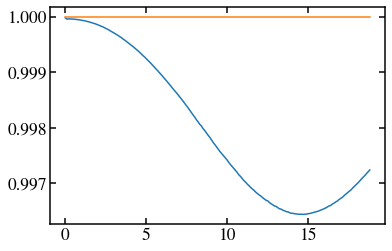

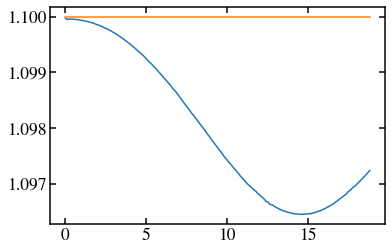

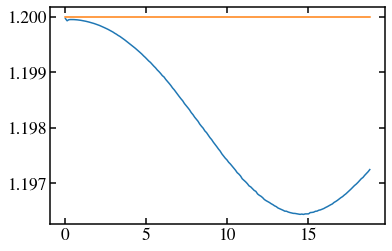

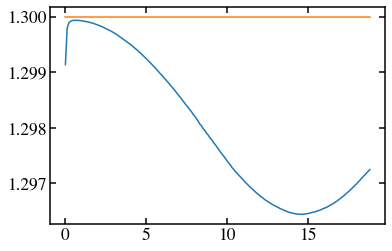

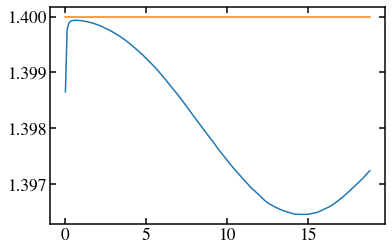

In [175]:
for i, u in enumerate([2.0, 2.2, 2.4, 2.6, 2.8]):
    w, gr, gi = np.loadtxt(f'./test_LR2/Bethe_41_beta{beta:d}/Giwn_recon-{u:.2f}.dat', \
                                                                       unpack=True, dtype='float64')
    w, sr, si = np.loadtxt(f'./test_LR2/Bethe_41_beta{beta:d}/self_energy_recon-{u:.2f}.dat', \
                                                                       unpack=True, dtype='float64')

    g = gr + 1j*gi
    s = iwn  + u/2 - 0.25*g - 1/g
    #s = sr + 1j*si
    plt.plot(w, s.real)

    w, gr, gi = np.loadtxt(f'../1_QMC/train/Bethe_41_beta{beta:d}/Giwn-{u:.2f}.dat', \
                                                                       unpack=True, dtype='float64')
    w, sr, si = np.loadtxt(f'../1_QMC/train/Bethe_41_beta{beta:d}/self_energy-{u:.2f}.dat', \
                                                                       unpack=True, dtype='float64')

    g = gr + 1j*gi
    s = sr + 1j*si
    plt.plot(w, s.real)
    plt.show()

(0.0, 0.25)

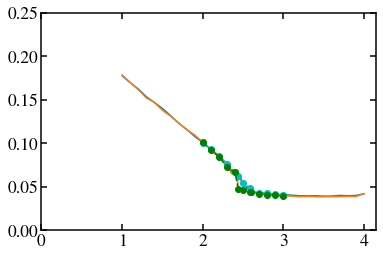

In [81]:
beta = 60
niwn = 180
ntau = niwn*5
iwn = np.array([1j*(2*n+1)*np.pi/beta for n in range(niwn)])
tau = np.linspace(0, beta, ntau)

U = np.array([0.01*i for i in range(100, 401)])
Ur_up, Ur_dn = [], []
for i, u in enumerate(U):
    if path.isfile(f'../1_QMC/train/Bethe_14_beta{beta:d}/Giwn-{u:.2f}.dat')==True: Ur_up.append(u)
    if path.isfile(f'../1_QMC/train/Bethe_41_beta{beta:d}/Giwn-{u:.2f}.dat')==True: Ur_dn.append(u)
Ur_up = np.array(Ur_up)
Ur_dn = np.array(Ur_dn)
Ur_len = len(Ur_up)+len(Ur_dn)
UUr = np.concatenate([Ur_up, Ur_dn])

docc_up = np.zeros_like(Ur_up)
docc_dn = np.zeros_like(Ur_dn)

for i,u in enumerate(Ur_up):
    w, gr, gi = np.loadtxt(f'../1_QMC/train/Bethe_14_beta{beta:d}/Giwn-{u:.2f}.dat', \
                                                                   unpack=True, dtype='float64')
    w, sr, si = np.loadtxt(f'../1_QMC/train/Bethe_14_beta{beta:d}/self_energy-{u:.2f}.dat', \
                                                                   unpack=True, dtype='float64')
    
    g = gr + 1j*gi
    s = sr + 1j*si
    I = gftools.GreenInverseFourier(g*s, ntau, beta, [-u/2, 0, 0])
    docc_up[i] = I[0]/u
    
for i,u in enumerate(Ur_dn):
    w, gr, gi = np.loadtxt(f'../1_QMC/train/Bethe_41_beta{beta:d}/Giwn-{u:.2f}.dat', \
                                                                   unpack=True, dtype='float64')
    w, sr, si = np.loadtxt(f'../1_QMC/train/Bethe_41_beta{beta:d}/self_energy-{u:.2f}.dat', \
                                                                   unpack=True, dtype='float64')
    
    g = gr + 1j*gi
    s = sr + 1j*si
    I = gftools.GreenInverseFourier(g*s, ntau, beta, [-u/2, 0, 0])
    docc_dn[i] = I[0]/u
    
plt.plot(Ur_up, docc_up)
plt.plot(Ur_dn, docc_dn)

UU, docc_up = np.loadtxt('docc_up.txt', unpack=True, dtype = 'float64')
UU, docc_dn = np.loadtxt('docc_dn.txt', unpack=True, dtype = 'float64')
plt.plot(UU, docc_up, 'co--')
plt.plot(UU, docc_dn, 'go--')
plt.xlim(0)
plt.ylim(0, 0.25)